In [12]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


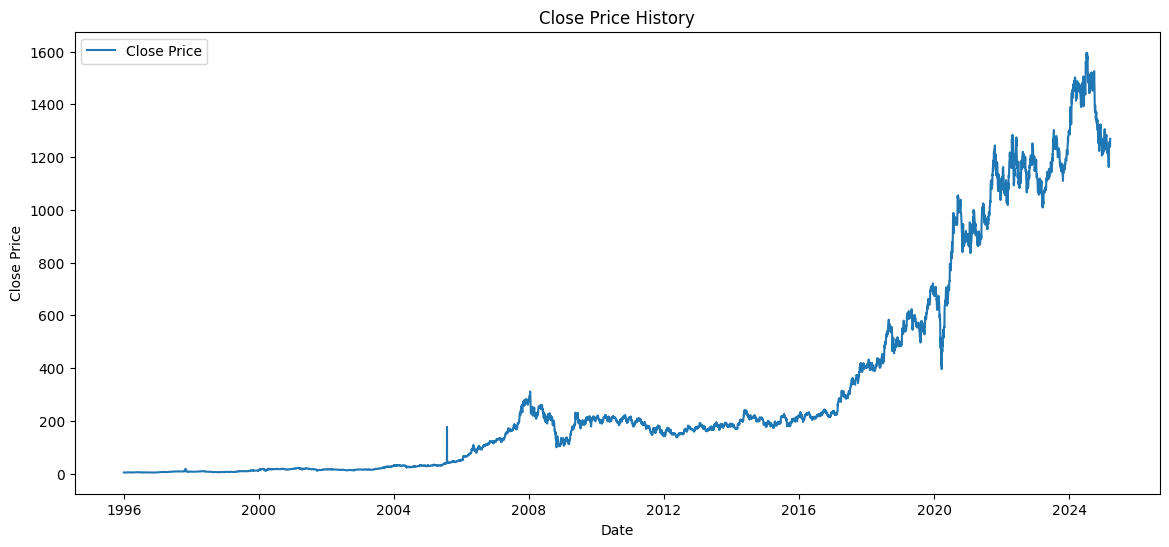

In [13]:

import pandas as pd

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the data
import pandas as pd

# Read data from CSV file
df = pd.read_csv('nse/RELIANCE.csv', skiprows=2,
                 names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])

# Remove rows where 'Date' column mistakenly contains the string 'Date'
df = df[df['Date'] != 'Date']

# Convert 'Date' to datetime format and handle errors explicitly
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['Date'], inplace=True)

# Sort by Date, set as index, and drop any remaining NaN values
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Optional: Reorder columns to standard format
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [14]:
# Data preprocessing
def preprocess_lstm_data(df, column='Close', time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[column]])

    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

time_step = 60
X, y, scaler = preprocess_lstm_data(df)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:

# Build the stacked LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)


Epoch 1/20


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 8.9545e-04
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 3.4579e-05
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 2.6866e-05
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 4.0732e-05
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 3.2782e-05
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 3.2397e-05
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 3.4416e-05
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 2.3214e-05
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 2.2975e-05
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 2.1035e-05
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 2.1024e-05
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.9105e-05
Epoch 13/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.1482e-05
Epoch 14/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 1.6669

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
RMSE: 23.142144040904782
MAE: 17.706691134106986


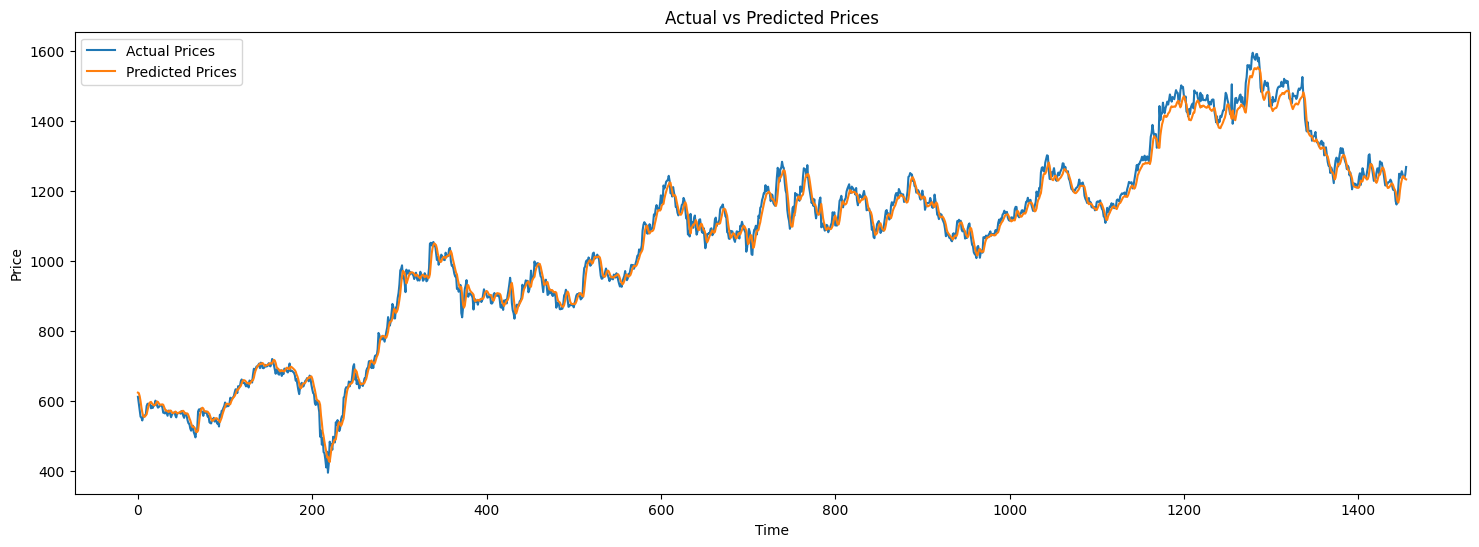

In [16]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot predictions vs actual
plt.figure(figsize=(18, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
# Save the trained model
model.save('stacked_lstm_model.keras')


In [ ]:
# LSTM Stock Forecasting Script for Existing + Future Data

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load dataset
file_path = "nse/RELIANCE.csv"  # Change path as needed
df = pd.read_csv(file_path, skiprows=2, names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
df = df[df['Date'] != 'Date']  # Remove malformed rows
df['Close'] = df['Close'].astype(float)
df = df.sort_values('Date')

# Normalize 'Close' column
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

# Sequence creation function
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First layer
    LSTM(50, return_sequences=True),                                     # Second layer
    LSTM(50),                                                            # Third (last) layer
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Test set prediction
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)
y_test_actual = scaler.inverse_transform(y_test)

# Forecast next 30 days
future_input = scaled_data[-60:]
future_predictions = []

for _ in range(30):
    pred = model.predict(future_input.reshape(1, 60, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse scale forecast
forecasted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Plotting results
plt.figure(figsize=(14, 6))
plt.plot(df['Close'][-len(y_test_actual):].index, y_test_actual, label='Actual')
plt.plot(df['Close'][-len(predicted_test):].index, predicted_test, label='Predicted')
plt.title("LSTM Test Set Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot future forecast
plt.figure(figsize=(10, 4))
plt.plot(range(1, 31), forecasted_prices, marker='o')
plt.title("Next 30 Days Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Price")
plt.grid(True)
plt.show()

# Print metrics
mse = mean_squared_error(y_test_actual, predicted_test)
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")

Epoch 1/20


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# LSTM Stock Forecasting Script for Testing Future Forecasting Accuracy

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load dataset
file_path = "nse/RELIANCE.csv"  # Change path as needed
df = pd.read_csv(file_path, skiprows=2, names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
df = df[df['Date'] != 'Date']  # Remove malformed rows
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
df = df.sort_values('Date')

# Use last 6 months data for future forecasting accuracy test
last_6_months = df[df['Date'] >= (df['Date'].max() - pd.DateOffset(months=6))]
data = last_6_months['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Train on first part, test on last 20%
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build Stacked LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict on test set
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)
y_test_actual = scaler.inverse_transform(y_test)

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', linewidth=2)
plt.plot(predicted_test, label='Predicted Price', linestyle='--')
plt.title("RELIANCE Stock Price Forecasting Accuracy (Last 6 Months)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
mse = mean_squared_error(y_test_actual, predicted_test)
mae = mean_absolute_error(y_test_actual, predicted_test)
print(f"Test MSE (Last 6 Months): {mse:.2f}")
print(f"Test MAE (Last 6 Months): {mae:.2f}")
